# KNN: Praktická implementace a optimalizace

## Cíl lekce

Po dokončení této lekce budete:
- **Rozumět problému škálování dat** a proč je kritický pro KNN
- **Znát rozdíl** mezi Min-Max škálováním a standardizací
- **Umět použít sklearn** pro profesionální implementaci KNN
- **Chápat cross-validation** pro nalezení optimálního K
- **Znát metriky hodnocení** pro klasifikaci a regresi
- **Rozumět curse of dimensionality** a jeho dopadu na KNN

## Problém škálování dat

### Kritický problém KNN - různé jednotky

KNN počítá **vzdálenosti** mezi body. Co se stane, když features mají různé škály?

### Příklad problému:

Předpovídáme, zda zákazník koupí produkt na základě:
- **Věk:** 25-65 let (rozsah 40)
- **Roční plat:** 30,000-150,000 Kč (rozsah 120,000)

### Výpočet vzdálenosti BEZ škálování:

| Zákazník | Věk | Plat (Kč) | Koupil |
|----------|-----|-----------|--------|
| A | 30 | 50,000 | Ano |
| B | 35 | 55,000 | Ano |
| Nový | 31 | 120,000 | ??? |

Vzdálenost Nový→A: $\sqrt{(31-30)^2 + (120000-50000)^2} = \sqrt{1 + 4,900,000,000} ≈ 70,000$

Vzdálenost Nový→B: $\sqrt{(31-35)^2 + (120000-55000)^2} = \sqrt{16 + 4,225,000,000} ≈ 65,000$

### Co je špatně?

- **Věk přispěl:** 1 a 16 jednotek
- **Plat přispěl:** 4,900,000,000 a 4,225,000,000 jednotek!

**Plat ÚPLNĚ dominuje** výpočtu vzdálenosti! Věk se prakticky ignoruje.

### Důsledky neškálovaných dat:

1. **Features s velkými hodnotami dominují**
2. **Features s malými hodnotami jsou ignorovány**
3. **Model se učí špatné vzory**
4. **Výsledky jsou nespolehlivé**

### Řešení: ŠKÁLOVÁNÍ DAT

Převedeme všechny features na **stejnou škálu** → všechny mají stejnou důležitost

## Typy škálování dat

### 1. Min-Max škálování (Normalizace)

Převede data do rozsahu **[0, 1]** nebo **[a, b]**.

#### Vzorec:

$$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

#### Vysvětlení symbolů:
- **$x_{scaled}$** = hodnota po škálování (výsledek)
- **$x$** = původní hodnota
- **$x_{min}$** = minimální hodnota v datasetu
- **$x_{max}$** = maximální hodnota v datasetu
- **$(x - x_{min})$** = posun tak, aby minimum bylo 0
- **$(x_{max} - x_{min})$** = rozsah původních dat

#### Příklad Min-Max škálování:

| Původní věk | Výpočet | Škálovaný věk |
|------------|---------|---------------|
| 25 (min) | (25-25)/(65-25) = 0/40 | 0.00 |
| 35 | (35-25)/(65-25) = 10/40 | 0.25 |
| 45 | (45-25)/(65-25) = 20/40 | 0.50 |
| 55 | (55-25)/(65-25) = 30/40 | 0.75 |
| 65 (max) | (65-25)/(65-25) = 40/40 | 1.00 |

#### Vlastnosti Min-Max škálování:
- ✅ **Zachovává vztahy** mezi hodnotami
- ✅ **Jasný rozsah** [0, 1]
- ❌ **Citlivé na outliers** - jeden extrém změní škálu všech
- ❌ **Nezachovává tvar distribuce**

---

### 2. Standardizace (Z-score normalizace)

Převede data tak, aby měla **průměr = 0** a **směrodatnou odchylku = 1**.

#### Vzorec:

$$z = \frac{x - \mu}{\sigma}$$

#### Vysvětlení symbolů:
- **$z$** = standardizovaná hodnota (z-score)
- **$x$** = původní hodnota
- **$\mu$** (řecké písmeno "mí") = průměr všech hodnot
- **$\sigma$** (řecké písmeno "sigma") = směrodatná odchylka
- **$(x - \mu)$** = odchylka od průměru
- **$\frac{}{\sigma}$** = dělení směrodatnou odchylkou

#### Příklad standardizace:

Data: [20, 30, 40, 50, 60]
- Průměr (μ) = 40
- Směrodatná odchylka (σ) = 14.14

| Původní hodnota | Výpočet | Z-score |
|----------------|---------|----------|
| 20 | (20-40)/14.14 | -1.41 |
| 30 | (30-40)/14.14 | -0.71 |
| 40 | (40-40)/14.14 | 0.00 |
| 50 | (50-40)/14.14 | 0.71 |
| 60 | (60-40)/14.14 | 1.41 |

#### Vlastnosti standardizace:
- ✅ **Robustní vůči outliers** (méně citlivé než Min-Max)
- ✅ **Zachovává tvar distribuce**
- ✅ **Vhodné pro normálně rozdělená data**
- ❌ **Nemá fixní rozsah** (hodnoty mohou být kdekoli)

---

### Kdy použít které škálování?

| Situace | Doporučení | Důvod |
|---------|------------|-------|
| **Data bez outliers** | Min-Max | Jasný rozsah [0,1] |
| **Data s outliers** | Standardizace | Robustnější |
| **Známý rozsah** (např. procenta) | Min-Max | Zachová interpretaci |
| **Neznámý rozsah** | Standardizace | Flexibilnější |
| **KNN algoritmus** | Obojí funguje | Záleží na datech |
| **Neural networks** | Často Min-Max | Aktivační funkce |
| **Lineární regrese** | Standardizace | Pro interpretaci koeficientů |

## Volba K - teorie

### Jak vybrat správné K?

Volba K je **kritické rozhodnutí** které ovlivňuje výkon modelu.

### Vliv K na model:

| K | Charakteristika | Výhody | Nevýhody |
|---|-----------------|--------|----------|
| **Malé K (1-3)** | Model je velmi flexibilní | • Zachytí lokální struktury<br>• Rychlé rozhodování | • **Overfitting** - příliš citlivý na šum<br>• Nestabilní predikce |
| **Střední K (5-15)** | Vyvážený model | • Dobrý kompromis<br>• Stabilní predikce | • Může přehlédnout jemné detaily |
| **Velké K (20+)** | Model je rigidní | • Odolný vůči šumu<br>• Hladké hranice | • **Underfitting** - ignoruje lokální vzory<br>• Pomalé (musí zpracovat mnoho sousedů) |

### Faktory ovlivňující volbu K:

1. **Velikost datasetu**
   - Malý dataset (< 100): K = 3-5
   - Střední dataset (100-1000): K = 5-15
   - Velký dataset (> 1000): K = 10-30

2. **Šum v datech**
   - Čistá data: Menší K je OK
   - Zašuměná data: Větší K pro robustnost

3. **Počet tříd**
   - 2 třídy: Liché K (3, 5, 7...)
   - Více tříd: K > počet tříd

### Cross-validation pro optimální K

**Cross-validation** je technika pro objektivní vyhodnocení modelu.

#### Jak funguje k-fold cross-validation:

1. **Rozděl data** na k částí (folds)
2. **Trénuj** na k-1 částech
3. **Testuj** na zbývající části
4. **Opakuj** k-krát (každá část je jednou testovací)
5. **Průměruj** výsledky

#### Příklad 3-fold cross-validation:

```
Data: [A, B, C, D, E, F, G, H, I]

Fold 1: Train=[D,E,F,G,H,I]  Test=[A,B,C]  → Accuracy=0.85
Fold 2: Train=[A,B,C,G,H,I]  Test=[D,E,F]  → Accuracy=0.90
Fold 3: Train=[A,B,C,D,E,F]  Test=[G,H,I]  → Accuracy=0.88

Průměrná accuracy = (0.85 + 0.90 + 0.88) / 3 = 0.876
```

#### Proces výběru K pomocí cross-validation:

1. Vyber rozsah K (např. 1 až 20)
2. Pro každé K:
   - Proveď cross-validation
   - Zaznamenej průměrnou accuracy
3. Vyber K s nejlepší accuracy

### Elbow Method (Metoda lokte)

Grafická metoda pro nalezení optimálního K:
1. Vykresli accuracy vs. K
2. Najdi "loket" - bod kde se zlepšení zpomaluje
3. To je optimální K

```
Accuracy
   ^
0.95|       _______________  
0.90|     /↗ "loket"        ← plató
0.85|   /                     
0.80| /                       
0.75|/                        
    +-------------------→ K
    1  3  5  7  9  11  13  15
```

## Curse of Dimensionality (Prokletí dimenzionality)

### Co to je?

**Curse of dimensionality** je jev, kdy se algoritmy založené na vzdálenosti (jako KNN) **dramaticky zhoršují** s rostoucím počtem dimenzí (features).

### Intuitivní vysvětlení:

#### V 2D prostoru (2 features):
```
    •  •
  •  X  •    X = nový bod
    •  •     Sousedé jsou blízko
```

#### V 100D prostoru (100 features):
```
•     •     •
              X = nový bod  
   •     •    Všichni jsou daleko!
```

### Matematický důvod:

S rostoucí dimenzí roste "objem" prostoru exponenciálně:
- **2D:** Plocha = strana²
- **3D:** Objem = strana³
- **100D:** Hyperobjem = strana¹⁰⁰ (!)

Data se "ztrácejí" v obrovském prostoru.

### Problémy ve vysokých dimenzích:

| Dimenze | Problém | Důsledek pro KNN |
|---------|---------|------------------|
| **Vzdálenosti se stávají podobné** | Všechny body jsou přibližně stejně daleko | Těžké najít "nejbližší" sousedy |
| **Data jsou řídká** | Mezi body je hodně "prázdného" prostoru | Sousedé nejsou skutečně podobní |
| **Potřeba více dat** | Exponenciálně více dat pro pokrytí prostoru | Málo dat = špatné výsledky |
| **Náhoda dominuje** | Náhodné features mají větší vliv | Model se učí šum místo vzorů |

### Konkrétní příklad:

| Dimenze | Body potřebné pro "hustotu" | Relativní vzdálenost k nejbližšímu |
|---------|------------------------------|-------------------------------------|
| 2D | 100 | 1.0 |
| 5D | 3,200 | 2.3 |
| 10D | 10,000,000 | 5.1 |
| 20D | 10²⁰ | 11.2 |
| 100D | 10¹⁰⁰ | Všichni stejně daleko |

### Řešení curse of dimensionality:

1. **Redukce dimenzí**
   - PCA (Principal Component Analysis)
   - Feature selection (vybrat jen důležité)
   - Feature extraction

2. **Více dat**
   - Exponenciálně více s každou dimenzí
   - Často nereálné

3. **Jiný algoritmus**
   - SVM funguje lépe ve vysokých dimenzích
   - Deep learning zvládá vysoké dimenze

### Praktické doporučení pro KNN:

| Počet features | Doporučení |
|---------------|------------|
| < 5 | KNN funguje výborně |
| 5-10 | KNN stále dobrý |
| 10-20 | Zvažte redukci dimenzí |
| > 20 | KNN pravděpodobně není vhodný |

## Metriky hodnocení

### Metriky pro KLASIFIKACI

#### 1. Accuracy (Přesnost)

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

**Vysvětlení symbolů:**
- **TP** (True Positive) = správně předpovězené pozitivní případy
- **TN** (True Negative) = správně předpovězené negativní případy  
- **FP** (False Positive) = chybně předpovězené jako pozitivní (ve skutečnosti negativní)
- **FN** (False Negative) = chybně předpovězené jako negativní (ve skutečnosti pozitivní)
- **Čitatel** = všechny správné předpovědi
- **Jmenovatel** = všechny předpovědi celkem

**Interpretace:** Kolik procent předpovědí bylo správných?

#### 2. Precision (Přesnost pozitivní třídy)

$$Precision = \frac{TP}{TP + FP}$$

**Vysvětlení:**
- **Čitatel** = správně předpovězené pozitivní
- **Jmenovatel** = všechny předpovězené jako pozitivní

**Interpretace:** Z těch co jsme označili jako pozitivní, kolik jich skutečně bylo pozitivních?

#### 3. Recall (Senzitivita)

$$Recall = \frac{TP}{TP + FN}$$

**Vysvětlení:**
- **Čitatel** = správně předpovězené pozitivní
- **Jmenovatel** = všechny skutečně pozitivní

**Interpretace:** Kolik procent skutečně pozitivních případů jsme našli?

---

### Metriky pro REGRESI

#### 1. Mean Squared Error (MSE)

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

**Vysvětlení symbolů:**
- **MSE** = průměrná kvadratická chyba
- **$\frac{1}{n}$** = průměrování (dělení počtem)
- **$n$** = počet pozorování
- **$\sum_{i=1}^{n}$** = součet přes všechna pozorování
- **$y_i$** = skutečná hodnota i-tého pozorování
- **$\hat{y}_i$** = předpovězená hodnota i-tého pozorování
- **$(y_i - \hat{y}_i)$** = chyba (reziduum)
- **$()^2$** = umocnění na druhou

**Interpretace:** Průměr čtverců chyb. Velké chyby jsou penalizovány více.

#### 2. Mean Absolute Error (MAE)

$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

**Vysvětlení symbolů:**
- **MAE** = průměrná absolutní chyba
- **$|\cdot|$** = absolutní hodnota (vždy kladná)
- Ostatní symboly stejné jako u MSE

**Interpretace:** Průměrná velikost chyby. Všechny chyby mají stejnou váhu.

#### 3. R² (Koeficient determinace)

$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

**Vysvětlení symbolů:**
- **$R^2$** = koeficient determinace
- **$\bar{y}$** = průměr skutečných hodnot
- **Čitatel zlomku** = součet čtverců reziduí (chyby modelu)
- **Jmenovatel zlomku** = celková variabilita dat

**Interpretace:** 
- R² = 1.0 → perfektní model
- R² = 0.7 → model vysvětluje 70% variability
- R² = 0.0 → model není lepší než průměr

## Confusion Matrix (Matice záměn)

### Co je Confusion Matrix?

**Confusion Matrix** je tabulka, která ukazuje, jak dobře klasifikátor funguje porovnáním skutečných a předpovězených tříd.

### Struktura pro binární klasifikaci:

|  | **Předpověď: Pozitivní** | **Předpověď: Negativní** |
|---------|-------------------------|-------------------------|
| **Skutečnost: Pozitivní** | True Positive (TP) | False Negative (FN) |
| **Skutečnost: Negativní** | False Positive (FP) | True Negative (TN) |

### Konkrétní příklad - Detekce spamu:

Testovali jsme spam filter na 100 emailech:

|  | **Předpověď: Spam** | **Předpověď: Ne-spam** | **Celkem** |
|---------|---------------------|------------------------|------------|
| **Skutečnost: Spam** | TP = 35 | FN = 5 | 40 |
| **Skutečnost: Ne-spam** | FP = 3 | TN = 57 | 60 |
| **Celkem** | 38 | 62 | 100 |

### Interpretace hodnot:

- **TP = 35:** Správně jsme označili 35 spamů jako spam ✅
- **TN = 57:** Správně jsme označili 57 normálních emailů jako ne-spam ✅
- **FP = 3:** Chybně jsme označili 3 normální emaily jako spam ❌ ("falešný poplach")
- **FN = 5:** Chybně jsme označili 5 spamů jako ne-spam ❌ (spam prošel)

### Výpočet metrik z Confusion Matrix:

| Metrika | Výpočet | Hodnota | Interpretace |
|---------|---------|---------|---------------|
| **Accuracy** | (35+57)/(35+57+3+5) | 92/100 = **92%** | Celková přesnost |
| **Precision** | 35/(35+3) | 35/38 = **92.1%** | Když řekneme "spam", jak často máme pravdu |
| **Recall** | 35/(35+5) | 35/40 = **87.5%** | Kolik spamů jsme chytili |
| **Specificity** | 57/(57+3) | 57/60 = **95%** | Kolik ne-spamů jsme správně pustili |

### Kdy je která metrika důležitá?

| Situace | Důležitá metrika | Důvod |
|---------|------------------|--------|
| **Detekce rakoviny** | Vysoký Recall | Nechceme přehlédnout žádný případ |
| **Spam filter** | Vysoká Precision | Nechceme mazat důležité emaily |
| **Vyvážený problém** | Accuracy | Celkový výkon je důležitý |
| **Nevyvážené třídy** | Precision & Recall | Accuracy může být zavádějící |

### Confusion Matrix pro více tříd:

Pro 3 třídy (A, B, C):

|  | **Předp: A** | **Předp: B** | **Předp: C** |
|---|--------------|--------------|---------------|
| **Skut: A** | 45 | 3 | 2 |
| **Skut: B** | 5 | 38 | 7 |
| **Skut: C** | 1 | 4 | 45 |

**Diagonála** = správné předpovědi
**Mimo diagonálu** = chyby (ukazují, které třídy si model plete)

## Složitost algoritmu KNN

### Časová složitost

#### Training (učení):
$$O(1)$$

**Vysvětlení:** 
- KNN je "lazy learning" algoritmus
- Při trénování **pouze uloží data** do paměti
- Žádné výpočty, žádná optimalizace
- Konstantní čas nezávislý na velikosti dat

#### Prediction (předpověď) - pro JEDEN nový bod:
$$O(n \times d)$$

**Vysvětlení symbolů:**
- **$O()$** = notace složitosti ("řádově")
- **$n$** = počet trénovacích bodů
- **$d$** = počet dimenzí (features)
- **$n \times d$** = musíme spočítat vzdálenost ke každému bodu v každé dimenzi

#### Konkrétní příklad časů:

| Trénovací data | Dimenze | Operací pro 1 predikci | Čas (přibližně) |
|---------------|---------|------------------------|------------------|
| 100 bodů | 2D | 100 × 2 = 200 | < 1 ms |
| 1,000 bodů | 10D | 1,000 × 10 = 10,000 | ~1 ms |
| 10,000 bodů | 100D | 10,000 × 100 = 1,000,000 | ~100 ms |
| 1,000,000 bodů | 1000D | 1,000,000 × 1000 = 10⁹ | ~10 sekund! |

### Paměťová složitost

$$O(n \times d)$$

**Vysvětlení:**
- Musíme uložit **všechna trénovací data**
- Každý bod má $d$ hodnot
- Celkem $n$ bodů

#### Konkrétní příklad paměti:

| Trénovací data | Dimenze | Paměť (float32) |
|---------------|---------|------------------|
| 1,000 bodů | 10D | 40 KB |
| 10,000 bodů | 100D | 4 MB |
| 100,000 bodů | 1000D | 400 MB |
| 1,000,000 bodů | 1000D | 4 GB! |

### Srovnání s jinými algoritmy:

| Algoritmus | Training | Prediction | Paměť |
|------------|----------|------------|--------|
| **KNN** | O(1) ⚡ | O(n×d) 🐌 | O(n×d) 😰 |
| **Decision Tree** | O(n×log n) | O(log n) ⚡ | O(n) |
| **Linear Regression** | O(d³) | O(d) ⚡ | O(d) ⚡ |
| **Neural Network** | O(iterace×n×parametry) 🐌 | O(parametry) | O(parametry) |

### Optimalizace KNN:

#### 1. KD-Tree
- Rozdělí prostor do stromové struktury
- Zrychlí vyhledávání: O(log n) místo O(n)
- Funguje dobře pro d < 20

#### 2. Ball Tree
- Používá hypersféry místo hyperrovin
- Lepší pro vysoké dimenze než KD-Tree

#### 3. Approximate Nearest Neighbors
- Najde "skoro" nejbližší sousedy
- Mnohem rychlejší
- Mírná ztráta přesnosti

### Praktické důsledky:

✅ **KNN je dobrý když:**
- Dataset je malý (< 10,000 bodů)
- Málo dimenzí (< 20)
- Nepotřebujeme rychlé predikce

❌ **KNN není vhodný když:**
- Dataset je obrovský (miliony bodů)
- Real-time aplikace (potřeba rychlých predikcí)
- Omezená paměť (mobilní zařízení)

## Import knihoven

Nyní, když rozumíme všem teoretickým konceptům, můžeme importovat potřebné knihovny pro praktickou implementaci:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Nastavení pro hezčí grafy
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Seed pro reprodukovatelnost
np.random.seed(42)

## Implementace v sklearn - Kompletní příklad

In [2]:
# Vytvoření jednoduchého datasetu - studenti
# Features: hodiny učení, hodiny spánku
# Target: prošel (1) / neprošel (0)

# Generování dat
n_samples = 30

# Studenti, kteří prošli (více učení, méně spánku)
prosli_uceni = np.random.normal(7, 1.5, n_samples//2)
prosli_spanek = np.random.normal(6, 1, n_samples//2)
prosli_label = np.ones(n_samples//2)

# Studenti, kteří neprošli (méně učení, více spánku)
neprosli_uceni = np.random.normal(3, 1.5, n_samples//2)
neprosli_spanek = np.random.normal(8, 1, n_samples//2)
neprosli_label = np.zeros(n_samples//2)

# Spojení dat
X = np.column_stack([
    np.concatenate([prosli_uceni, neprosli_uceni]),
    np.concatenate([prosli_spanek, neprosli_spanek])
])
y = np.concatenate([prosli_label, neprosli_label])

# Rozdělení na trénovací a testovací data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Trénovací data: {X_train.shape[0]} studentů")
print(f"Testovací data: {X_test.shape[0]} studentů")
print(f"Počet features: {X_train.shape[1]}")

Trénovací data: 21 studentů
Testovací data: 9 studentů
Počet features: 2


## Ukázka problému škálování

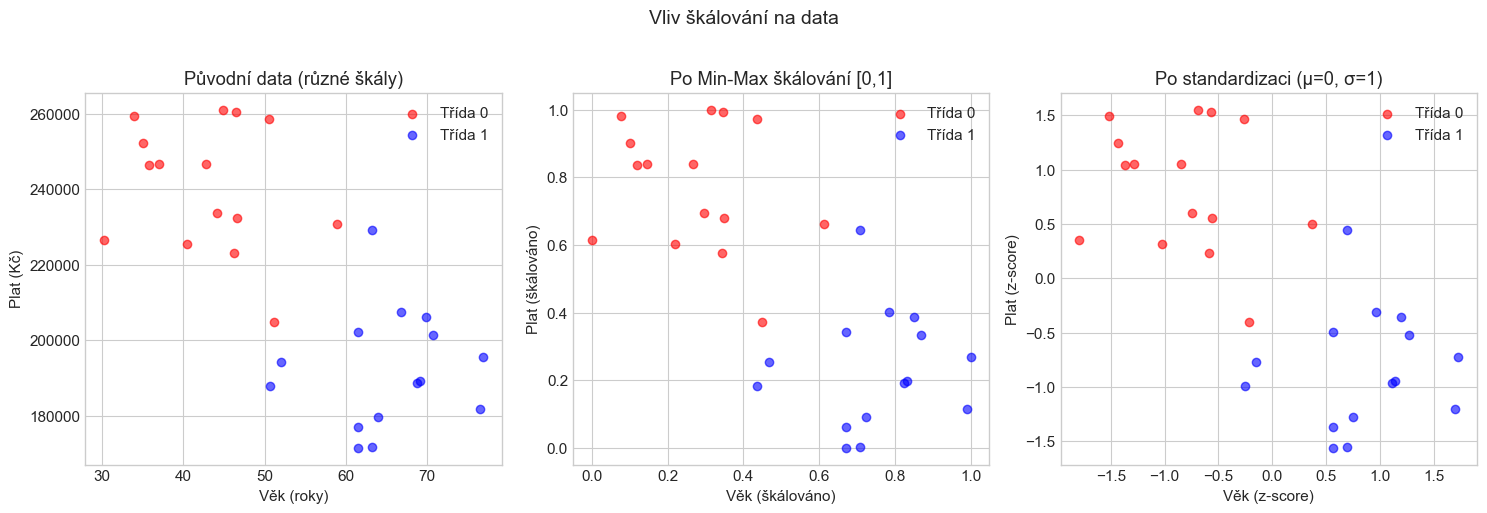


Vzdálenost mezi body 1 a 2:
Bez škálování: 9010.87
Po standardizaci: 0.48

Bez škálování dominuje plat (rozdíl tisíců), věk je zanedbatelný!


In [3]:
# Vytvoříme dataset s velmi různými škálami
# Feature 1: Věk (20-60 let)
# Feature 2: Roční plat (20,000-200,000 Kč)

X_unscaled = X.copy()
X_unscaled[:, 0] = X_unscaled[:, 0] * 5 + 30  # Věk: ~20-60
X_unscaled[:, 1] = X_unscaled[:, 1] * 20000 + 80000  # Plat: ~20k-200k

# Vizualizace vlivu škálování
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Původní data (různé škály)
axes[0].scatter(X_unscaled[y==0, 0], X_unscaled[y==0, 1], c='red', label='Třída 0', alpha=0.6)
axes[0].scatter(X_unscaled[y==1, 0], X_unscaled[y==1, 1], c='blue', label='Třída 1', alpha=0.6)
axes[0].set_xlabel('Věk (roky)')
axes[0].set_ylabel('Plat (Kč)')
axes[0].set_title('Původní data (různé škály)')
axes[0].legend()

# 2. Min-Max škálování
scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X_unscaled)
axes[1].scatter(X_minmax[y==0, 0], X_minmax[y==0, 1], c='red', label='Třída 0', alpha=0.6)
axes[1].scatter(X_minmax[y==1, 0], X_minmax[y==1, 1], c='blue', label='Třída 1', alpha=0.6)
axes[1].set_xlabel('Věk (škálováno)')
axes[1].set_ylabel('Plat (škálováno)')
axes[1].set_title('Po Min-Max škálování [0,1]')
axes[1].legend()

# 3. Standardizace
scaler_standard = StandardScaler()
X_standard = scaler_standard.fit_transform(X_unscaled)
axes[2].scatter(X_standard[y==0, 0], X_standard[y==0, 1], c='red', label='Třída 0', alpha=0.6)
axes[2].scatter(X_standard[y==1, 0], X_standard[y==1, 1], c='blue', label='Třída 1', alpha=0.6)
axes[2].set_xlabel('Věk (z-score)')
axes[2].set_ylabel('Plat (z-score)')
axes[2].set_title('Po standardizaci (μ=0, σ=1)')
axes[2].legend()

plt.suptitle('Vliv škálování na data', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Ukázka, jak škálování ovlivňuje vzdálenosti
point1 = X_unscaled[0]
point2 = X_unscaled[1]
dist_original = np.sqrt(np.sum((point1 - point2)**2))

point1_scaled = X_standard[0]
point2_scaled = X_standard[1]
dist_scaled = np.sqrt(np.sum((point1_scaled - point2_scaled)**2))

print(f"\nVzdálenost mezi body 1 a 2:")
print(f"Bez škálování: {dist_original:.2f}")
print(f"Po standardizaci: {dist_scaled:.2f}")
print(f"\nBez škálování dominuje plat (rozdíl tisíců), věk je zanedbatelný!")

## KNN klasifikace s sklearn

In [4]:
# Standardizace dat
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Použijeme stejný scaler!

# Vytvoření a trénování KNN klasifikátoru
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Predikce
y_pred = knn.predict(X_test_scaled)

# Vyhodnocení
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN s K={k}")
print(f"Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Neprošel', 'Prošel']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print("                Předpověď")
print("                Neprošel  Prošel")
print(f"Skutečnost Neprošel    {cm[0,0]}        {cm[0,1]}")
print(f"           Prošel      {cm[1,0]}        {cm[1,1]}")

KNN s K=5
Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

    Neprošel       1.00      1.00      1.00         6
      Prošel       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9


Confusion Matrix:
                Předpověď
                Neprošel  Prošel
Skutečnost Neprošel    6        0
           Prošel      0        3


## Cross-validation pro volbu optimálního K

In [5]:
# Testování různých hodnot K pomocí cross-validation
k_values = range(1, 16)
cv_scores_mean = []
cv_scores_std = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

# Najdeme optimální K
optimal_k = k_values[np.argmax(cv_scores_mean)]
print(f"Optimální K: {optimal_k}")
print(f"Nejlepší CV accuracy: {max(cv_scores_mean):.3f}")

Optimální K: 4
Nejlepší CV accuracy: 1.000


In [6]:
cv_scores_mean

[0.95,
 0.9,
 0.95,
 1.0,
 1.0,
 0.96,
 0.9099999999999999,
 0.9099999999999999,
 0.9099999999999999,
 0.95,
 0.95,
 0.95,
 0.9099999999999999,
 0.9099999999999999,
 0.62]